In [1]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import numpy as np

import hiive.mdptoolbox.mdp as mdp
import hiive.mdptoolbox.example as example

import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

In [2]:
# helper function to plot curves
def make_plot(x_values, y_values_dict, x_label, y_label):
    
    fig = plt.figure()
    ax = plt.gca()
    for key in y_values_dict.keys():
        ax.plot(x_values, y_values_dict[key], label=key)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    title = '{} as a function of {}'.format(y_label, x_label)
    ax.set_title(title)
    ax.legend()

In [3]:
# action mapping for visualization
action_mapping = {
    3: '↑', 
    2: '→',
    1: '↓',
    0: '←'
}

## Set problem parameters for 4x4 lake

In [4]:
np.random.seed(2020)
random_map = generate_random_map(size=4, p=0.8)
environment = gym.make("FrozenLake-v0", desc=random_map)

In [5]:
states = environment.nS
actions = environment.nA

In [6]:
P = np.zeros((actions, states, states))
R = np.zeros((states, actions))

for state in range(states):
    for action in range(actions):
        for data in environment.P[state][action]:
            proba, next_state, reward, done = data
            R[state, action] = reward
            P[action, state, next_state] = proba
            P[action, state, :] = P[action, state, :] / np.sum(P[action, state, :])

In [7]:
gamma = 0.8
max_iter = 1000000
dims = (4,4)

## Policy Iteration

In [8]:
pi = mdp.PolicyIteration(P, R, gamma=gamma, max_iter=max_iter)
pi_result = pi.run()

In [9]:
pi_iters = [iteration['Iteration'] for iteration in pi_result]
pi_errors = [iteration['Error'] for iteration in pi_result]
pi_times = [iteration['Time'] for iteration in pi_result]
pi_rewards = [iteration['Mean V'] for iteration in pi_result]

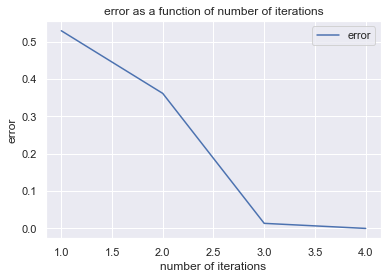

In [10]:
make_plot(pi_iters, {'error': pi_errors}, 'number of iterations', 'error')

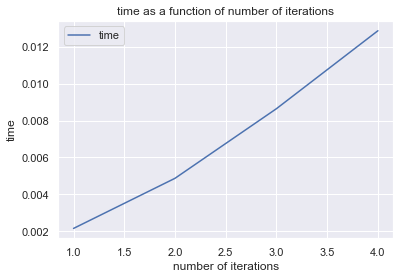

In [11]:
make_plot(pi_iters, {'time': np.cumsum(pi_times)}, 'number of iterations', 'time')

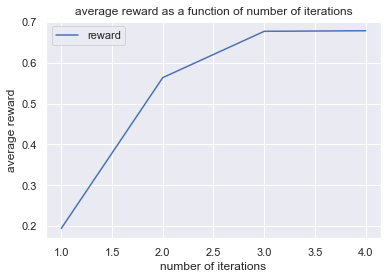

In [12]:
make_plot(pi_iters, {'reward': pi_rewards}, 'number of iterations', 'average reward')

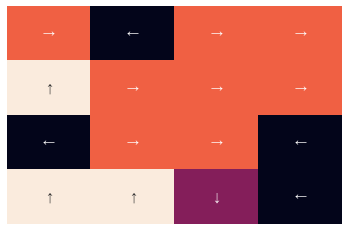

In [13]:
sns.heatmap(np.array(pi.policy).reshape(dims), 
            annot=np.array(list(map(lambda x: action_mapping[x], pi.policy))).reshape(dims), 
            fmt='',  
            xticklabels='', 
            yticklabels='',
            cbar=False);

## Value Iteration

In [14]:
vi = mdp.ValueIteration(P, R, gamma=gamma, max_iter=max_iter)
vi_result = vi.run()

In [15]:
vi_iters = [iteration['Iteration'] for iteration in vi_result]
vi_errors = [iteration['Error'] for iteration in vi_result]
vi_times = [iteration['Time'] for iteration in vi_result]
vi_rewards = [iteration['Mean V'] for iteration in vi_result]

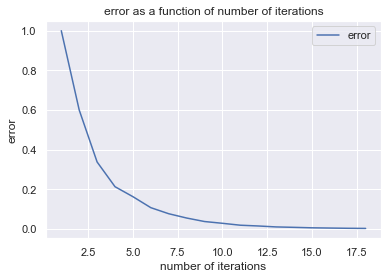

In [16]:
make_plot(vi_iters, {'error': vi_errors}, 'number of iterations', 'error')

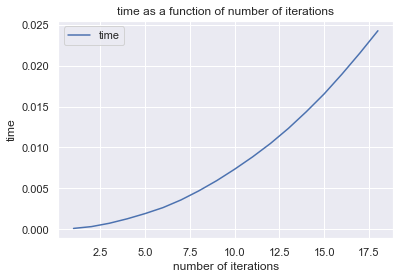

In [17]:
make_plot(vi_iters, {'time': np.cumsum(vi_times)}, 'number of iterations', 'time')

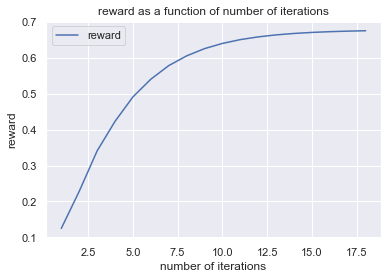

In [18]:
make_plot(vi_iters, {'reward': vi_rewards}, 'number of iterations', 'reward')

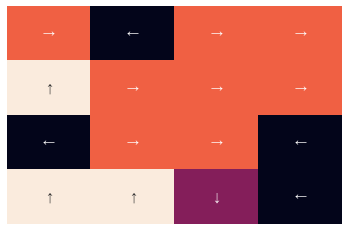

In [19]:
sns.heatmap(np.array(vi.policy).reshape(dims), 
            annot=np.array(list(map(lambda x: action_mapping[x], vi.policy))).reshape(dims), 
            fmt='',  
            xticklabels='', 
            yticklabels='',
            cbar=False);

## Q-learning

In [20]:
epsilon_range = [0.1, 0.9, 0.99]
alpha_range = [0.3, 0.6, 0.9]
alpha_decay = 0.2
epsilon_decay = 0.999999

In [21]:
%%time
results = {}

for epsilon in epsilon_range:
    for alpha in alpha_range:
        ql = mdp.QLearning(P, R, gamma=gamma, 
                           alpha=alpha, 
                           alpha_decay=alpha_decay,
                           epsilon=epsilon, 
                           epsilon_decay=epsilon_decay,
                           n_iter=max_iter)
        ql_result = ql.run()
        
        temp = {}
        temp['ql_iters'] = [iteration['Iteration'] for iteration in ql_result]
        temp['ql_errors'] = [iteration['Error'] for iteration in ql_result]
        temp['ql_times'] = [iteration['Time'] for iteration in ql_result]
        
        results[(epsilon, alpha)] = temp

CPU times: user 6min 6s, sys: 4.69 s, total: 6min 11s
Wall time: 6min 20s


In [22]:
error_data = {}
for epsilon, alpha in results.keys():
    error_data['error; eps: {} lr: {}'.format(epsilon, alpha)] = results[(epsilon, alpha)]['ql_errors']

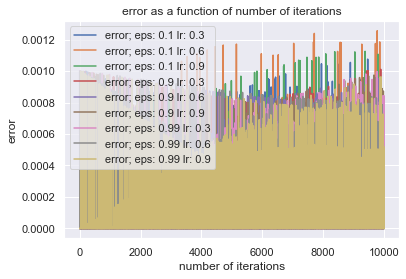

In [23]:
make_plot(list(range(0,int(max_iter/100))), error_data, 'number of iterations', 'error')

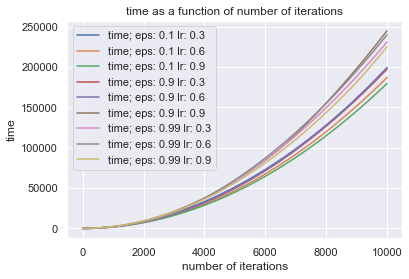

In [24]:
time_data = {}
for epsilon, alpha in results.keys():
    time_data['time; eps: {} lr: {}'.format(epsilon, alpha)] = np.cumsum(results[(epsilon, alpha)]['ql_times'])
make_plot(list(range(0,int(max_iter/100))), time_data, 'number of iterations', 'time')

In [25]:
ql = mdp.QLearning(P, R, gamma=gamma, 
                   alpha=0.3, 
                   alpha_decay=alpha_decay,
                   epsilon=0.99, 
                   epsilon_decay=epsilon_decay,
                   n_iter=max_iter)
ql_result = ql.run()

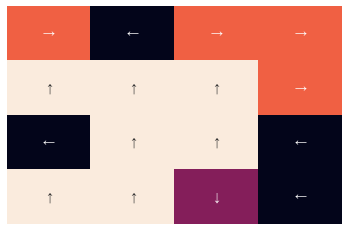

In [26]:
sns.heatmap(np.array(ql.policy).reshape(dims), 
            annot=np.array(list(map(lambda x: action_mapping[x], ql.policy))).reshape(dims), 
            fmt='',  
            xticklabels='', 
            yticklabels='',
            cbar=False);

## Set problem parameters for 15x15 lake

In [27]:
np.random.seed(2020)
random_map = generate_random_map(size=15, p=0.8)
environment = gym.make("FrozenLake-v0", desc=random_map)

In [28]:
states = environment.nS
actions = environment.nA

In [29]:
P = np.zeros((actions, states, states))
R = np.zeros((states, actions))

for state in range(states):
    for action in range(actions):
        for data in environment.P[state][action]:
            proba, next_state, reward, done = data
            R[state, action] = reward
            P[action, state, next_state] = proba
            P[action, state, :] = P[action, state, :] / np.sum(P[action, state, :])

In [30]:
gamma = 0.8
max_iter = 1000000
dims = (15,15)

## Policy Iteration

In [31]:
pi = mdp.PolicyIteration(P, R, gamma=gamma, max_iter=max_iter)
pi_result = pi.run()

In [32]:
pi_iters = [iteration['Iteration'] for iteration in pi_result]
pi_errors = [iteration['Error'] for iteration in pi_result]
pi_times = [iteration['Time'] for iteration in pi_result]
pi_rewards = [iteration['Mean V'] for iteration in pi_result]

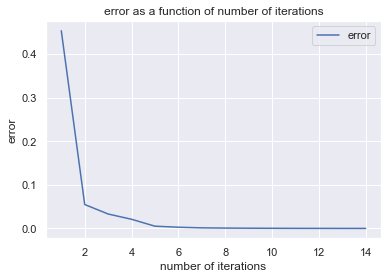

In [33]:
make_plot(pi_iters, {'error': pi_errors}, 'number of iterations', 'error')

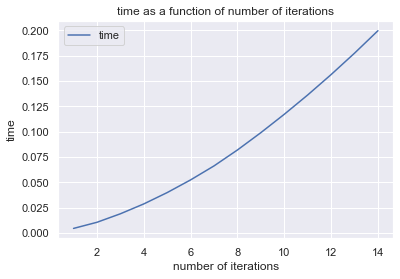

In [34]:
make_plot(pi_iters, {'time': np.cumsum(pi_times)}, 'number of iterations', 'time')

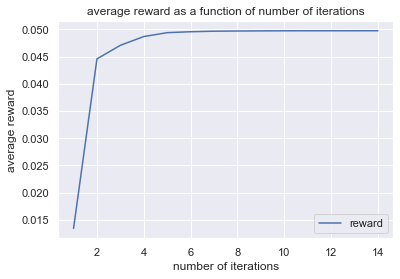

In [35]:
make_plot(pi_iters, {'reward': pi_rewards}, 'number of iterations', 'average reward')

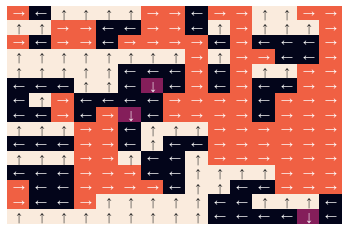

In [36]:
sns.heatmap(np.array(pi.policy).reshape(dims), 
            annot=np.array(list(map(lambda x: action_mapping[x], pi.policy))).reshape(dims), 
            fmt='',  
            xticklabels='', 
            yticklabels='',
            cbar=False);

## Value Iteration

In [37]:
vi = mdp.ValueIteration(P, R, gamma=gamma, max_iter=max_iter)
vi_result = vi.run()

In [38]:
vi_iters = [iteration['Iteration'] for iteration in vi_result]
vi_errors = [iteration['Error'] for iteration in vi_result]
vi_times = [iteration['Time'] for iteration in vi_result]
vi_rewards = [iteration['Mean V'] for iteration in vi_result]

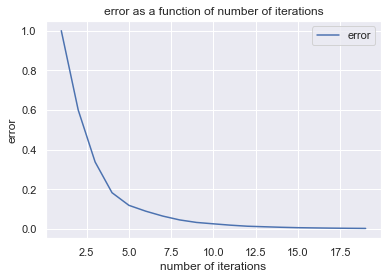

In [39]:
make_plot(vi_iters, {'error': vi_errors}, 'number of iterations', 'error')

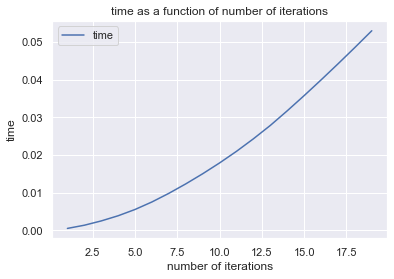

In [40]:
make_plot(vi_iters, {'time': np.cumsum(vi_times)}, 'number of iterations', 'time')

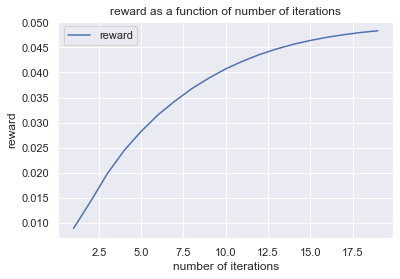

In [41]:
make_plot(vi_iters, {'reward': vi_rewards}, 'number of iterations', 'reward')

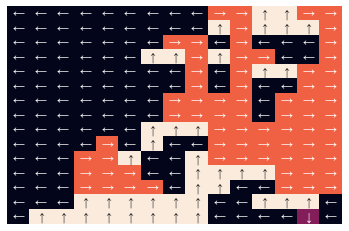

In [42]:
sns.heatmap(np.array(vi.policy).reshape(dims), 
            annot=np.array(list(map(lambda x: action_mapping[x], vi.policy))).reshape(dims), 
            fmt='',  
            xticklabels='', 
            yticklabels='',
            cbar=False);

## Q-learning

In [43]:
epsilon_range = [0.1, 0.9, 0.99]
alpha_range = [0.3, 0.6, 0.9]
alpha_decay = 0.2
epsilon_decay = 0.999999

In [44]:
%%time
results = {}

for epsilon in epsilon_range:
    for alpha in alpha_range:
        ql = mdp.QLearning(P, R, gamma=gamma, 
                           alpha=alpha, 
                           alpha_decay=alpha_decay,
                           epsilon=epsilon, 
                           epsilon_decay=epsilon_decay,
                           n_iter=max_iter)
        ql_result = ql.run()
        
        temp = {}
        temp['ql_iters'] = [iteration['Iteration'] for iteration in ql_result]
        temp['ql_errors'] = [iteration['Error'] for iteration in ql_result]
        temp['ql_times'] = [iteration['Time'] for iteration in ql_result]
        
        results[(epsilon, alpha)] = temp

CPU times: user 15min 20s, sys: 6.19 s, total: 15min 26s
Wall time: 16min 42s


In [45]:
error_data = {}
for epsilon, alpha in results.keys():
    error_data['error; eps: {} lr: {}'.format(epsilon, alpha)] = results[(epsilon, alpha)]['ql_errors']

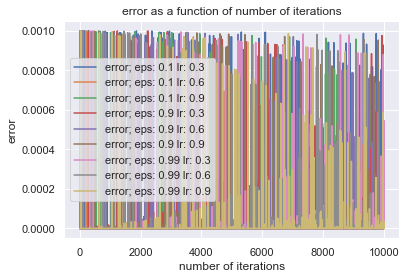

In [46]:
make_plot(list(range(0,int(max_iter/100))), error_data, 'number of iterations', 'error')

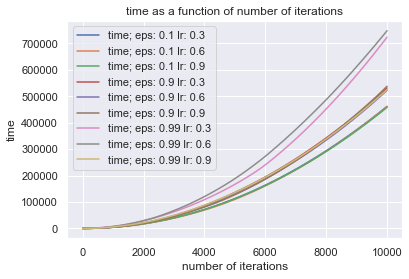

In [47]:
time_data = {}
for epsilon, alpha in results.keys():
    time_data['time; eps: {} lr: {}'.format(epsilon, alpha)] = np.cumsum(results[(epsilon, alpha)]['ql_times'])
make_plot(list(range(0,int(max_iter/100))), time_data, 'number of iterations', 'time')

In [48]:
ql = mdp.QLearning(P, R, gamma=gamma, 
                   alpha=0.3, 
                   alpha_decay=alpha_decay,
                   epsilon=0.99, 
                   epsilon_decay=epsilon_decay,
                   n_iter=max_iter)
ql_result = ql.run()

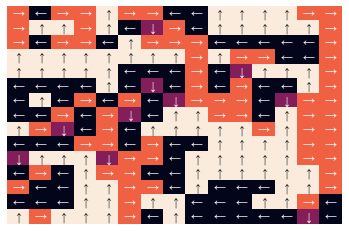

In [49]:
sns.heatmap(np.array(ql.policy).reshape(dims), 
            annot=np.array(list(map(lambda x: action_mapping[x], ql.policy))).reshape(dims), 
            fmt='',  
            xticklabels='', 
            yticklabels='',
            cbar=False);